# Project 3 Reddit API 

## Outline

1. [Problem statement](#Problem-Statement)
2. [Executive summary](#Executive-Summary)
3. [Methodology](#Methodology)
4. [Data Collection](#Data-Collection)  
5. [Data Cleaning](#Data-Cleaning)  
6. [EDA](#EDA)
7. [Modeling](#Modeling)  
    - [Logistic Regression](#Logistic-Regression)
    - [Multinomial Bayes](#Multinomial-Naive-Bayes)
    - [Decision Trees](#Decision-Trees)
    - [Bagging](#Bagging)
8. [Metrics](#Metrics-Against-Testing-Data)  
9. [Visualizations](#Visualizations)  
10. [Conclusions and Recomendations](#Conclusion-and-Recommendations)

## Problem Statement

Looking to learn about stock trading and different stock trading strategies? You might want to head over to reddit to see if there are existing subreddits solely dedicated to talking about stocks. Much to your advantage, there are a variety of subs dedicated to trading and different methodologies (forex, options, using robinhood specifically, weed stocks, etc). But where do you begin and how should you filter through the vast amount of information?  

Two very informative places to start are r/Stocks and r/Investing. However, you're a very busy person who doesn't have much time to be looking at **both** of these subreddits. These subreddits seem very similar, but on first glance, are you able to tell? Do you need to read both subreddits in order to be a well informed trader?

## Executive Summary

The two subreddits are very similar, from their names to their descriptions. r/Stocks is described as a place to talk all things stocks, be it buy/sell suggestions, tips, economic news, etc. r/Investing is not much different except it includes jargon about technical analysis. The model works to separate the two subreddits by their title only. 

The posts collected are almost evenly split, with r/Stocks making up 44% of the entire dataset and r/Investing making up 56%. There is a total of 1,687 posts collected. I ran through a variety of models in order to see how each model compared to the baseline. However, the accuracy score for the models were quite similar and did not do much better than the baseline accuracy. 

Although it could be a problem with the models themselves, I believe that these two subreddits content wise are not very different.

## Methodology

The first step was to collect the data from the subreddits. In order for the model to train with a balanced data set, I aimed to collect close to 1,000 posts from each subreddit. r/Stocks had a collection of 743 posts while r/StockMarket had a collection of 944. The combined dataset did not have a clean split between the two but was close enough for the model to work off of. 

To clean the data, repeated posts were removed based on their post names. Daily Discussion or Daily Question threads were removed as well. In order to work with a smaller number of features, the model only evaluated post titles. Even then, the total word count was 3,209 (using ngram (1,1)). The texts were split into features using either Count Vectorizer or TF-IDF Vectorizer. The models utilized were Logistic Regression, Multinomial Bayes, Decision Trees and Bagging. GridSearch was used to find the best parameters for the vectorizers and models. 

The model that was the most accurate was the Multinomial Bayes using TF-IDF vectorizer. The baseline accuracy was 55% and the model scored 64%. 

**Visualizations**  
The graph for the scatter plot using text was created using a library called Scatter Text created by Jason Kessler. The graph works to plot the frequency of words for both subreddits, each subreddit having an axis.  

The graph for the co-occurence of words was created using Gephi.

#### Load Libraries

In [3]:
import requests
import time

In [153]:
import pandas as pd
import numpy as np
import re

In [255]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [257]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix

## Data Collection

#### Subreddits to scrape

In [16]:
# URL to stocks subreddit
stocks = 'https://www.reddit.com/r/stocks.json'

In [176]:
# URL to Wall Street Bets subreddit
investing = 'https://www.reddit.com/r/investing.json'

#### Requesting data

In [177]:
# Specify user in order to get post information from subreddits
user_agent = {'User-agent': 'mimi-kim'}
res_stocks = requests.get(stocks, headers = user_agent)
res_investing = requests.get(investing, headers = user_agent)

#### Extracting Data

In [179]:
stocks_data = res_stocks.json()
invest_data = res_investing.json()

#### Automating Multiple Pull Requests

In [26]:
# Function to make multiple pull requests 
# Code from Boom

def get_data(subreddit, num):
    posts = []
    after = None
    for pull_num in range(num):


        # Create some kind of message to tell us which request number we're at
        print('Pulling data attempted', pull_num +1, 'times')

        # Using string concatenation, append this to the base URL
        if after == None: 
            new_url = subreddit
        else:
            new_url = subreddit+'?after='+after

        ##### PULLING REQUEST AND EXTRACTING THE DATA #####

        # Step 1: Make request
        res = requests.get(new_url, headers = user_agent)



        # Step 2: Extract data (but may want to extract some)
        if res.status_code == 200:
            json_data = res.json() #  Pull JSON
            posts.extend(json_data['data']['children'])     #  Get posts and extend the `posts` list


        # Step 3: Update the after string for next loop
            after = json_data['data']['after']
            # 'after' = ID of the last post in this pull iteration
        else:
            print("We've run into an error. The status code is:", res.status_code)
            break

        # Create a brief pause so the API doesn't lock you out by mistaking you for a machine
        time.sleep(2)
    return posts

We need to pull 40 times in order to reach close to 1,000 posts. We are assuming that reddit will allow us to pull a full 25 posts on each run.

In [180]:
# Pulling r/Stocks posts
data_stocks = get_data(stocks, 40)

Pulling data attempted 1 times
Pulling data attempted 2 times
Pulling data attempted 3 times
Pulling data attempted 4 times
Pulling data attempted 5 times
Pulling data attempted 6 times
Pulling data attempted 7 times
Pulling data attempted 8 times
Pulling data attempted 9 times
Pulling data attempted 10 times
Pulling data attempted 11 times
Pulling data attempted 12 times
Pulling data attempted 13 times
Pulling data attempted 14 times
Pulling data attempted 15 times
Pulling data attempted 16 times
Pulling data attempted 17 times
Pulling data attempted 18 times
Pulling data attempted 19 times
Pulling data attempted 20 times
Pulling data attempted 21 times
Pulling data attempted 22 times
Pulling data attempted 23 times
Pulling data attempted 24 times
Pulling data attempted 25 times
Pulling data attempted 26 times
Pulling data attempted 27 times
Pulling data attempted 28 times
Pulling data attempted 29 times
Pulling data attempted 30 times
Pulling data attempted 31 times
Pulling data atte

In [181]:
# The amount of unique posts we actually pulled
print("We have:", len(set([p['data']['name'] for p in data_stocks])), "posts in this subreddit")

We have: 765 posts in this subreddit


In [182]:
# Pulling r/StockMarket posts
data_markets = get_data(stock_market, 40)

Pulling data attempted 1 times
Pulling data attempted 2 times
Pulling data attempted 3 times
Pulling data attempted 4 times
Pulling data attempted 5 times
Pulling data attempted 6 times
Pulling data attempted 7 times
Pulling data attempted 8 times
Pulling data attempted 9 times
Pulling data attempted 10 times
Pulling data attempted 11 times
Pulling data attempted 12 times
Pulling data attempted 13 times
Pulling data attempted 14 times
Pulling data attempted 15 times
Pulling data attempted 16 times
Pulling data attempted 17 times
Pulling data attempted 18 times
Pulling data attempted 19 times
Pulling data attempted 20 times
Pulling data attempted 21 times
Pulling data attempted 22 times
Pulling data attempted 23 times
Pulling data attempted 24 times
Pulling data attempted 25 times
Pulling data attempted 26 times
Pulling data attempted 27 times
Pulling data attempted 28 times
Pulling data attempted 29 times
Pulling data attempted 30 times
Pulling data attempted 31 times
Pulling data atte

In [281]:
# Actual number of unique posts from r/StockMarket
print("We have:", len(set([p['data']['name'] for p in data_markets])), "posts in this subreddit")

We have: 966 posts in this subreddit


## Data Cleaning

#### Create a dictionary of each subreddit

In [229]:
stocks_posts = []
for posts in data_stocks:
    post = {} 
    
    # Remove punctuation
    post['title'] = re.sub('[^a-zA-Z]', " ", posts['data']['title'])
    post['name'] = posts['data']['name']
    stocks_posts.append(post)

In [230]:
# Transform the list of post dictionaries into a Data Frame
stocks_df = pd.DataFrame(stocks_posts)

In [233]:
invest_posts = []
for posts in data_markets:
    post = {}
    post['title'] = re.sub('[^a-zA-Z]', " ", posts['data']['title'])
    post['name'] = posts['data']['name']
    invest_posts.append(post)

In [234]:
# Transform the list of post dictionaries into a Data Frame
invest_df = pd.DataFrame(invest_posts)

In [231]:
# Remove duplicate posts
stocks_df.drop_duplicates(keep = 'first', inplace = True)
invest_df.drop_duplicates(keep = 'first', inplace = True)

In [238]:
# Save data as csv
stocks_df.to_csv('stocks_data.csv')
invest_df.to_csv('invest_data.csv')

In [294]:
# Create column for target Y variable 
# 0 for r/stocks and 1 for r/stockmarket
stocks_df['target'] = 0
invest_df['target'] = 1

In [295]:
combined_df = pd.concat([stocks_df, invest_df], ignore_index = True)

In [296]:
# Remove daily discussion thread and daily advice thread
combined_df.drop(combined_df[combined_df['title'].str.contains('Daily Discussion')].index, inplace = True)
combined_df.drop(combined_df[combined_df['title'].str.contains('Daily Advice')].index, inplace = True)

In [297]:
combined_df.reset_index(drop= True, inplace = True)

### EDA

In [77]:
# Applying count vectorizer to see how many features are extracted from the intial data frame
vectorizer = CountVectorizer(ngram_range = (1,1),
                            stop_words='english')

In [29]:
X_train_eda = vectorizer.fit_transform(X_train, y_train)

In [30]:
X_train_eda_df =pd.DataFrame(X_train_eda.toarray(),
                         columns = vectorizer.get_feature_names())

In [26]:
# Number of features with ngram range 1,1
X_train_eda_df.shape

(1265, 2862)

In [31]:
# Number of features with ngram range 1,2
X_train_eda_df.shape

(1265, 10988)

In [321]:
#  Number of features with ngram range 1,3
X_train_eda_df.shape

(1265, 19536)

It is useful to know how many features will be created by different ngram ranges. Based on different ngram features it will also dictate range for n_features in certain models.

In [78]:
# Vectorizing the r/Stocks data frame
text_stocks = vectorizer.fit_transform(stocks_df['title'])

In [79]:
# Vectorized r/Stocks data frame
text_stocks_df= pd.DataFrame(text_stocks.toarray(), 
                            columns = vectorizer.get_feature_names())

In [80]:
# Check to make sure that vectorizer worked
text_stocks_df.head()

,aapl,abbv,abbvie,ability,abmd,acb,account,accounting,accrued,accumulation,...,yields,yo,york,yoy,yr,zero,zillow,zion,znh,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [302]:
# Repeating the process for r/Investing data
text_investing = vectorizer.fit_transform(invest_df['title'])

In [305]:
text_investing_df = pd.DataFrame(text_investing.toarray(), 
                              columns= vectorizer.get_feature_names())

In [308]:
text_investing_df.head()

,000,0065,06,08,10,100,1000,10000,101,102,...,york,young,youtube,yr,yt,ytd,yum,zeitgeist,zillow,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
# Repeat steps above to vectorize the combined data frame
text_combined = vectorizer.fit_transform(combined_df['title'])

In [65]:
text_combined_df= pd.DataFrame(text_combined.toarray(), 
                            columns = vectorizer.get_feature_names())

In [81]:
# Top 10 words from r/Stocks
text_stocks_df.sum().sort_values(ascending = False)[0:10]

stock         85
stocks        82
thoughts      39
trading       35
amp           28
buy           28
market        28
company       25
daily         25
discussion    24
dtype: int64

In [60]:
# Top 10 words from r/Investing
text_investing_df.sum().sort_values(ascending = False)[0:10]

market       81
stock        79
investing    74
stocks       55
advice       49
funds        40
buy          40
good         34
vs           34
questions    30
dtype: int64

In [66]:
# Top 10 words from the combined data frame
text_combined_df.sum().sort_values(ascending = False)[0:10]

stock        164
stocks       115
market       109
investing     95
buy           68
thoughts      59
trading       54
good          51
company       49
funds         48
dtype: int64

Already from the top 10 words, you can see that there is a big over lap between the most frequent words used/seen from the two subreddits.

## Modeling

From the models below, it can be noted that changing from one model to another did not have a drastic increase or decrease in the accuracy score. Because the scores have little fluctuations, it should be noted that perhaps there is not much of a difference in the post contents from both subreddits. The scores were close to the baseline accuracy of 56%.

#### Baseline Accuracy

In [299]:
combined_df['target'].value_counts(normalize = True)

1    0.559573
0    0.440427
Name: target, dtype: float64

In [300]:
combined_df['target'].value_counts()

1    944
0    743
Name: target, dtype: int64

In [233]:
# Train-Test-Split our data for modeling purposes 
X = combined_df['title']
y = combined_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

### Logistic Regression

#### Count Vectorizer

In [234]:
pipe_cv = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())   
])

In [235]:
pipe_params = {
    'cvec__max_features': [500, 1000, 1250, 1500, 2500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__stop_words': ['english', None],
    'cvec__ngram_range': [(1,1), (1,2), (1, 3)]
}
gs_cv = GridSearchCV(pipe_cv, param_grid=pipe_params, cv=5)
gs_cv.fit(X_train, y_train)
print(gs_cv.best_score_)
gs_cv.best_params_

/Applications/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6252964426877471


{'cvec__max_df': 0.9,
 'cvec__max_features': 1250,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 3),
 'cvec__stop_words': None}

#### TFIDF Vectorizer

In [236]:
pipe_tf = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())   
])

In [237]:
pipe_params = {
    'tvec__max_features': [500, 1000, 1250, 1500, 2500],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__stop_words': ['english', None],
    'tvec__ngram_range': [(1,1), (1,2), (1, 3)]
}
gs_tf = GridSearchCV(pipe_tf, param_grid=pipe_params, cv=5)
gs_tf.fit(X_train, y_train)
print(gs_tf.best_score_)
gs_tf.best_params_

/Applications/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6316205533596838


{'tvec__max_df': 0.9,
 'tvec__max_features': 1250,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

### Multinomial Naive Bayes

#### Count Vectorizer

In [238]:
# With Count Vectorizer
pipe_mcv = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())   
])

In [240]:
pipe_params = {
    'cvec__max_features': [500, 1000, 1250, 1500, 2500],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__stop_words': ['english', None],
    'cvec__ngram_range': [(1,1), (1,2), (1, 3)]
}
gs_mcv = GridSearchCV(pipe_mcv, param_grid=pipe_params, cv=5)
gs_mcv.fit(X_train, y_train)
print(gs_mcv.best_score_)
gs_mcv.best_params_

0.6403162055335968


{'cvec__max_df': 0.9,
 'cvec__max_features': 1000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

#### TFIDF Vectorizer

In [241]:
# With TFIDF Vectorizer 
pipe_mtf = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())   
])

In [242]:
pipe_params = {
    'tvec__max_features': [500, 1000, 1250, 1500, 2500],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__stop_words': ['english', None],
    'tvec__ngram_range': [(1,1), (1,2), (1, 3)]
}
gs_mtf = GridSearchCV(pipe_mtf, param_grid=pipe_params, cv=5)
gs_mtf.fit(X_train, y_train)
print(gs_mtf.best_score_)
gs_mtf.best_params_

0.6276679841897234


{'tvec__max_df': 0.9,
 'tvec__max_features': 1250,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 3),
 'tvec__stop_words': None}

### Decision Trees

#### Count Vectorizer

In [301]:
pipe_dtc = Pipeline([
    ('cvec', CountVectorizer()),
    ('dt', DecisionTreeClassifier())   
])

In [244]:
pipe_params = {
    'cvec__max_features': [5000, 6000, 7500],
    'cvec__min_df': [2, 3, 4],
    'cvec__max_df': [.9, .95],
    'cvec__stop_words': ['english', None],
    'cvec__ngram_range': [(1,1), (1,2), (1, 3)],
    'dt__max_depth': [30, 50],
    'dt__min_samples_split': [2, 3]
    
}
gs_dtc = GridSearchCV(pipe_dtc, param_grid=pipe_params, cv=3)
gs_dtc.fit(X_train, y_train)
print(gs_dtc.best_score_)
gs_dtc.best_params_

0.5928853754940712


{'cvec__max_df': 0.95,
 'cvec__max_features': 6000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'dt__max_depth': 50,
 'dt__min_samples_split': 3}

#### TFIDF Vectorizer

In [245]:
pipe_dtt = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('dt', DecisionTreeClassifier())   
])

In [246]:
pipe_params = {
    'tvec__max_features': [6000, 7500, 10_000],
    'tvec__min_df': [3, 4, 5],
    'tvec__max_df': [.9, .95],
    'tvec__stop_words': ['english', None],
    'tvec__ngram_range': [(1,1), (1,2), (1, 3)],
    'dt__max_depth': [15, 20, 30]
    
}
gs_dtt = GridSearchCV(pipe_dtt, param_grid=pipe_params, cv=3)
gs_dtt.fit(X_train, y_train)
print(gs_dtt.best_score_)
gs_dtt.best_params_

0.5992094861660079


{'dt__max_depth': 20,
 'tvec__max_df': 0.9,
 'tvec__max_features': 10000,
 'tvec__min_df': 4,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': None}

### Bagging

#### Count Vectorizer

In [247]:
pipe_bgc = Pipeline([
    ('cvec', CountVectorizer()),
    ('bg', BaggingClassifier())   
])

In [248]:
pipe_params = {
    'cvec__max_features': [6000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__stop_words': ['english', None],
    'cvec__ngram_range': [(1,1), (1, 3)],
    'bg__n_estimators': [200]
    
}
gs_bgc = GridSearchCV(pipe_bgc, param_grid=pipe_params, cv=3)
gs_bgc.fit(X_train, y_train)
print(gs_bgc.best_score_)
gs_bgc.best_params_

0.6007905138339921


{'bg__n_estimators': 200,
 'cvec__max_df': 0.95,
 'cvec__max_features': 6000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 3),
 'cvec__stop_words': 'english'}

In [249]:
pipe_params = {
    'cvec__max_features': [6000],
    'cvec__min_df': [3],
    'cvec__max_df': [.95],
    'cvec__stop_words': ['english', None],
    'cvec__ngram_range': [(1,1), (1, 3)],
    'bg__n_estimators': [500]
    
}
gs_bgc2 = GridSearchCV(pipe_bgc, param_grid=pipe_params, cv=3)
gs_bgc2.fit(X_train, y_train)
print(gs_bgc2.best_score_)
gs_bgc2.best_params_

0.5992094861660079


{'bg__n_estimators': 500,
 'cvec__max_df': 0.95,
 'cvec__max_features': 6000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english'}

In the above, because these models took so long to run it was more efficient to run in different cell blocks to compare the changes rather than adding new parameter variables

In [250]:
pipe_bgt = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('bg', BaggingClassifier())   
])

In [251]:
pipe_params = {
    'tvec__max_features': [6000],
    'tvec__min_df': [3],
    'tvec__max_df': [.95],
    'tvec__stop_words': ['english', None],
    'tvec__ngram_range': [(1,1), (1, 3)],
    'bg__n_estimators': [100, 200]
    
}
gs_bgt = GridSearchCV(pipe_bgt, param_grid=pipe_params, cv=3)
gs_bgt.fit(X_train, y_train)
print(gs_bgt.best_score_)
gs_bgt.best_params_

0.5968379446640316


{'bg__n_estimators': 200,
 'tvec__max_df': 0.95,
 'tvec__max_features': 6000,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [252]:
pipe_params = {
    'tvec__max_features': [5000, 10_000],
    'tvec__min_df': [4, 5],
    'tvec__max_df': [.9, .95],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1,1), (1, 3)],
    'bg__n_estimators': [100, 200]
    
}
gs_bgt2 = GridSearchCV(pipe_bgt, param_grid=pipe_params, cv=3)
gs_bgt2.fit(X_train, y_train)
print(gs_bgt2.best_score_)
gs_bgt2.best_params_

0.5992094861660079


{'bg__n_estimators': 100,
 'tvec__max_df': 0.95,
 'tvec__max_features': 10000,
 'tvec__min_df': 5,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

Because the earlier models did not score very well on accuracy, I ran multiple models to see if the accuracy could have a greater difference from the baseline. However, as you can see from below, the scores did not vary too much from the models.

### Metrics Against Testing Data

In [314]:
print(f"The test score for log reg with cvec is {np.round(gs_cv.score(X_test, y_test),4)}, train score is {np.round(gs_cv.best_score_,4)}")
print(f"The testscore for log reg with tfidf is {np.round(gs_tf.score(X_test, y_test),4)}, train score is {np.round(gs_tf.best_score_,4)}")
print(f"The test score for bagging with cvec is {np.round(gs_bgc.score(X_test, y_test),4)}, train score is {np.round(gs_bgc.best_score_,4)}")
print(f"The test score for bagging with tfidf is {np.round(gs_bgt.score(X_test, y_test),4)}, train score is {np.round(gs_bgt.best_score_,4)}")
print(f"The test score for decision trees with tfidf is {np.round(gs_dtt.score(X_test, y_test),4)}, train score is {np.round(gs_dtt.best_score_,4)}")
print(f"The test score for decision trees with cvec is {np.round(gs_dtc.score(X_test, y_test),4)}, train score is {np.round(gs_dtc.best_score_,4)}")
print(f"The test score for multinomial bayes with cvec is {np.round(gs_mcv.score(X_test, y_test),4)}, train score is {np.round(gs_mcv.best_score_,4)}")
print(f"The test score for multinomial bayes with tfidf is {np.round(gs_mtf.score(X_test, y_test),4)}, train score is {np.round(gs_mtf.best_score_,4)}")



The test score for log reg with cvec is 0.6351, train score is 0.6253
The testscore for log reg with tfidf is 0.6256, train score is 0.6316
The test score for bagging with cvec is 0.6161, train score is 0.6008
The test score for bagging with tfidf is 0.6019, train score is 0.5968
The test score for decision trees with tfidf is 0.5972, train score is 0.5992
The test score for decision trees with cvec is 0.6019, train score is 0.5929
The test score for multinomial bayes with cvec is 0.6351, train score is 0.6403
The test score for multinomial bayes with tfidf is 0.6422, train score is 0.6277


The model that performed the best was the Multinomial Bayes using TFIDF vectorizer. 

In [266]:
# Since the best scoring model was multinomial bayes, use that model for confusion matrix
preds = gs_mtf.predict(X_test)
confusion_matrix(y_test, preds)

array([[ 71, 115],
       [ 36, 200]])

In [269]:
# Specifying the true negative, false positive, false negative and true positive for the above confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Calculate specificity
spec = tn/(tn + fp)

print(f'Specificity: {round(spec,4)}')

# Calculate sensitivity
sens = tp/(tp + fn)

print(f'Sensitivity: {round(sens,4)}')

# Calculate accuracy
accuracy = (tn+tp)/(tn+fp+fn+tp)
print(f'Accuracy: {round(accuracy,4)}')

Specificity: 0.3817
Sensitivity: 0.8475
Accuracy: 0.6422


The model performed well in terms of sensitivity but very poorly for specificity. The true positive rate was better, meaning that the model was able to predict when it was an r/Investing post than r/Stocks.

## Visualizations

In [343]:
import scattertext as st
import spacy
from pprint import pprint

In [344]:
# Change target to string in order to use with scatter text
combined_df['target'] = combined_df['target'].astype(str)

In [345]:
# Code for scatter text from 
# https://github.com/JasonKessler/scattertext

nlp = spacy.load('en')
corpus = st.CorpusFromPandas(combined_df,
                            category_col = 'target',
                            text_col = 'title',
                            nlp=nlp).build()

In [346]:
html = st.produce_scattertext_explorer(corpus,
          category= '0',
          category_name='Stocks',
          not_category_name='Investing',
          width_in_pixels=1000)
open("Convention-Visualization.html", 'wb').write(html.encode('utf-8'))

534285

The graph below plots the frequency of words for each subreddit on their own axis. The y-axis plots words for r/Investing while the X-axis plots words for r/Stocks. The right hand side columns show the top unique words for both of the subreddits as well as frequently discussed topics (characteristics).  

This graph is a powerful tool to see which words are commonly seen in both subreddits as well as individual unique words. It can be noted that words that appear frequently in both r/Stocks and r/Investing are 'market', 'investing' and 'stocks'.  

From the top unique words from each subreddits, it can be seen that r/Investing also has a focus on ETFs while r/Stocks incorporates more discussions about earnings releases.

In [353]:
from IPython.display import IFrame

IFrame('Convention-Visualization.html', width = 1300, height = 800)
# Clicking on a term will show the frequency of the word in each subreddit underneath the graph

Another way to visualize the frequency of words is through a tool called Gephi. By having a co-occurence matrix, Gephi will be able to plot the frequency of words that appear together as well as the frequency of the individual words themselves. 

In [323]:
# Make co-occurence matrix to plot with Gephi
# Multiply with the transposed vectorized dataframe to itself
X_investing = text_investing.T * text_investing

# Convert to array in order to fill the diagonal with zeroes, get rid of relation to same word
X_investing = X_investing.toarray()
np.fill_diagonal(X_investing, 0)

# Convert back to dataframe in order to export as csv to use with Gephi
X_investing2 = pd.DataFrame(X_investing, columns = text_investing_df.columns, index = text_investing_df.columns)



# Repeat for stocks subreddit
X_stocks = text_stocks.T * text_stocks 
X_stocks = X_stocks.toarray()
np.fill_diagonal(X_stocks, 0)
X_stocks2 = pd.DataFrame(X_stocks, columns = text_stocks_df.columns, index = text_stocks_df.columns)

# Save files as csv separated by commas
X_investing2.to_csv('./data/investing_gephi.csv', sep = ',')
X_stocks2.to_csv('./data/stocks_gephi.csv', sep = ',')

#Repeat for combined text dataframe
Xc = (text_combined.T * text_combined)
Xc_2 = pd.DataFrame(Xc.toarray(), columns = text_combined_df.columns)
Xc_2 = Xc.toarray()
np.fill_diagonal(Xc_2, 0)

co_occurence = pd.DataFrame(Xc_2, columns = text_combined_df.columns, index = text_combined_df.columns)

In [188]:
# Export to csv in order to use gephi 
# from https://www.pingshiuanchua.com/blog/post/keyword-network-analysis-with-python-and-gephi
co_occurence.to_csv('gephi.csv', sep = ',')

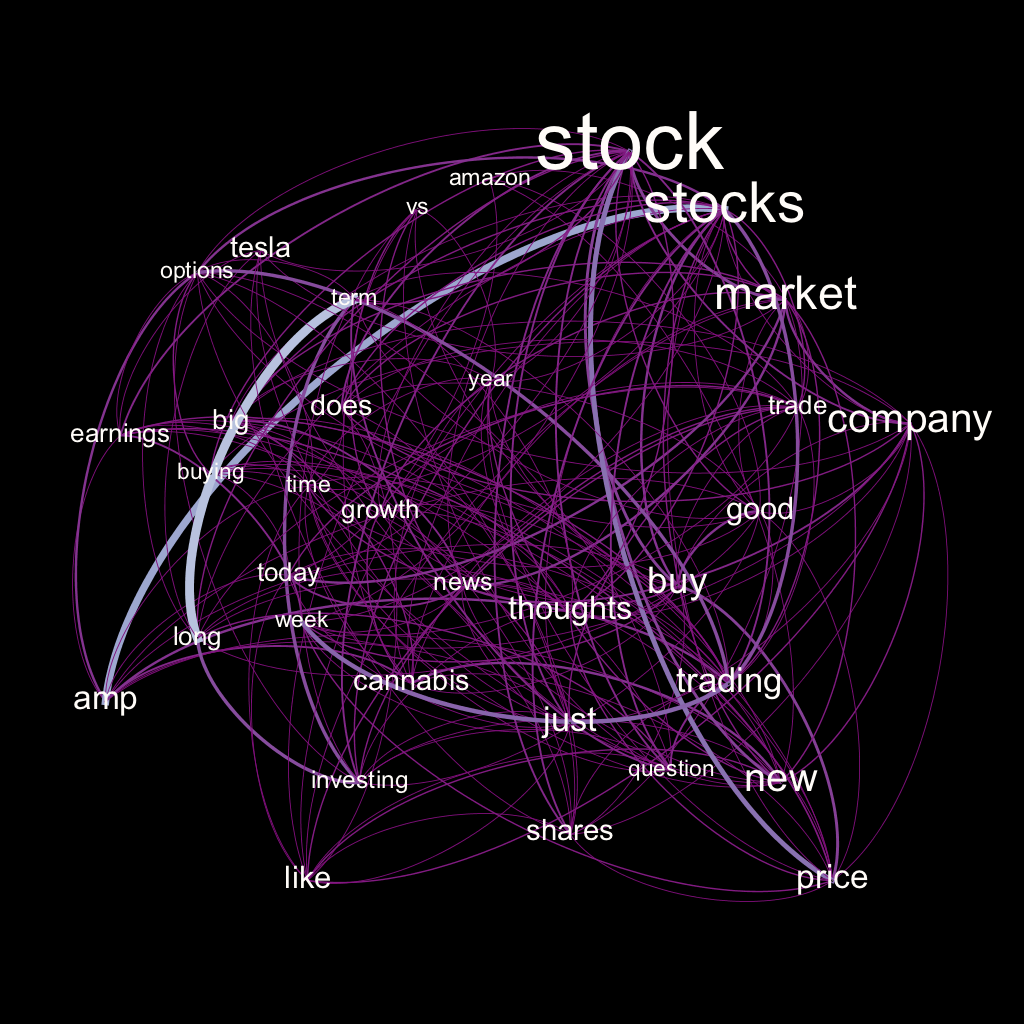

In [333]:
Image(filename = './images/stocks_gephi.png', width = 500)

The image above is a network graph for the r/Stocks subreddit. The most frequently used words are stock, stocks, market and company. The different line widths and colors indiciate the frequency of the words appearing together. For example, stock and price as well as long and term were frequently observed together.

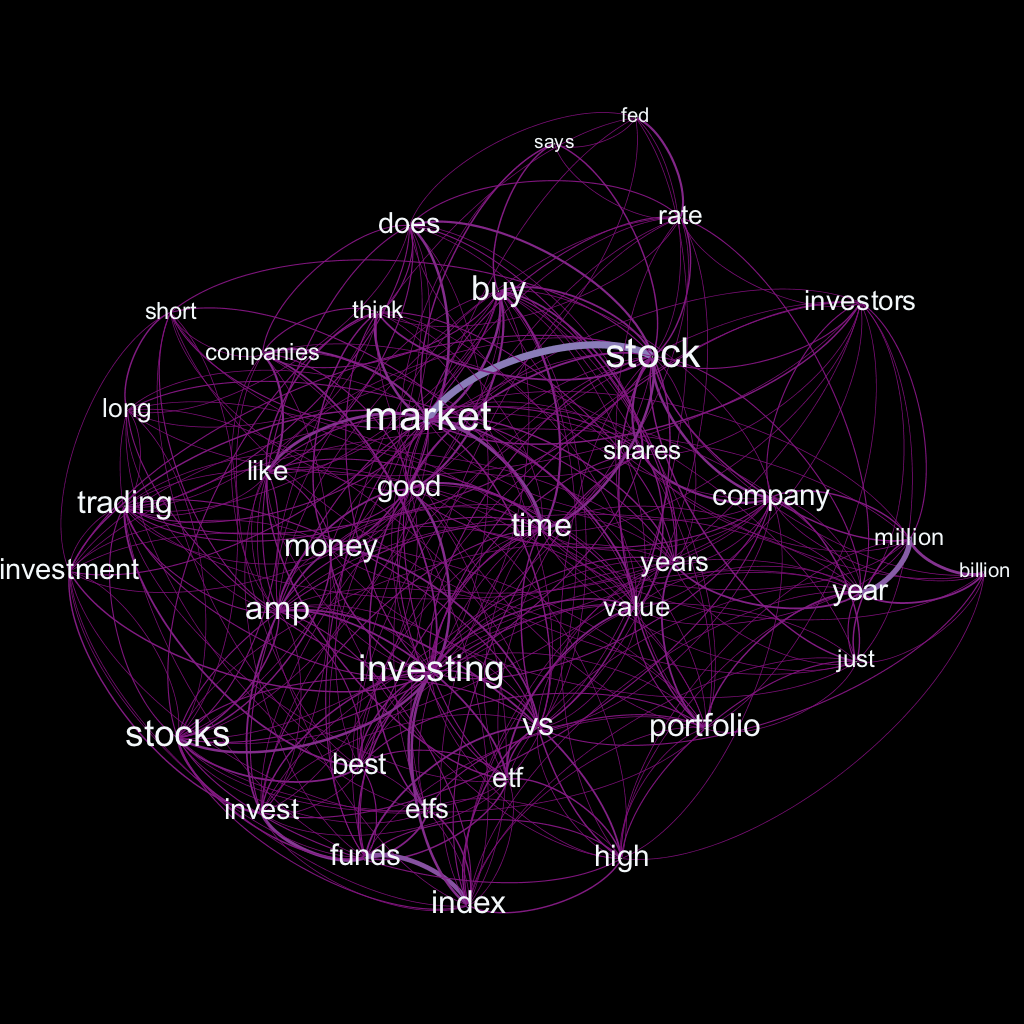

In [336]:
Image(filename = './images/investing_geph.png', width = 500)

This network graph shows the relationship of words in the r/Investing subreddit. It can be noted from the graph that r/Investing had more unique words as the size of the words do not have such a great size difference as compared to the r/Stocks network graph.  

The most used words were stock, market and stocks. Stock and market as well as index and funds appeared the most commonly together. 

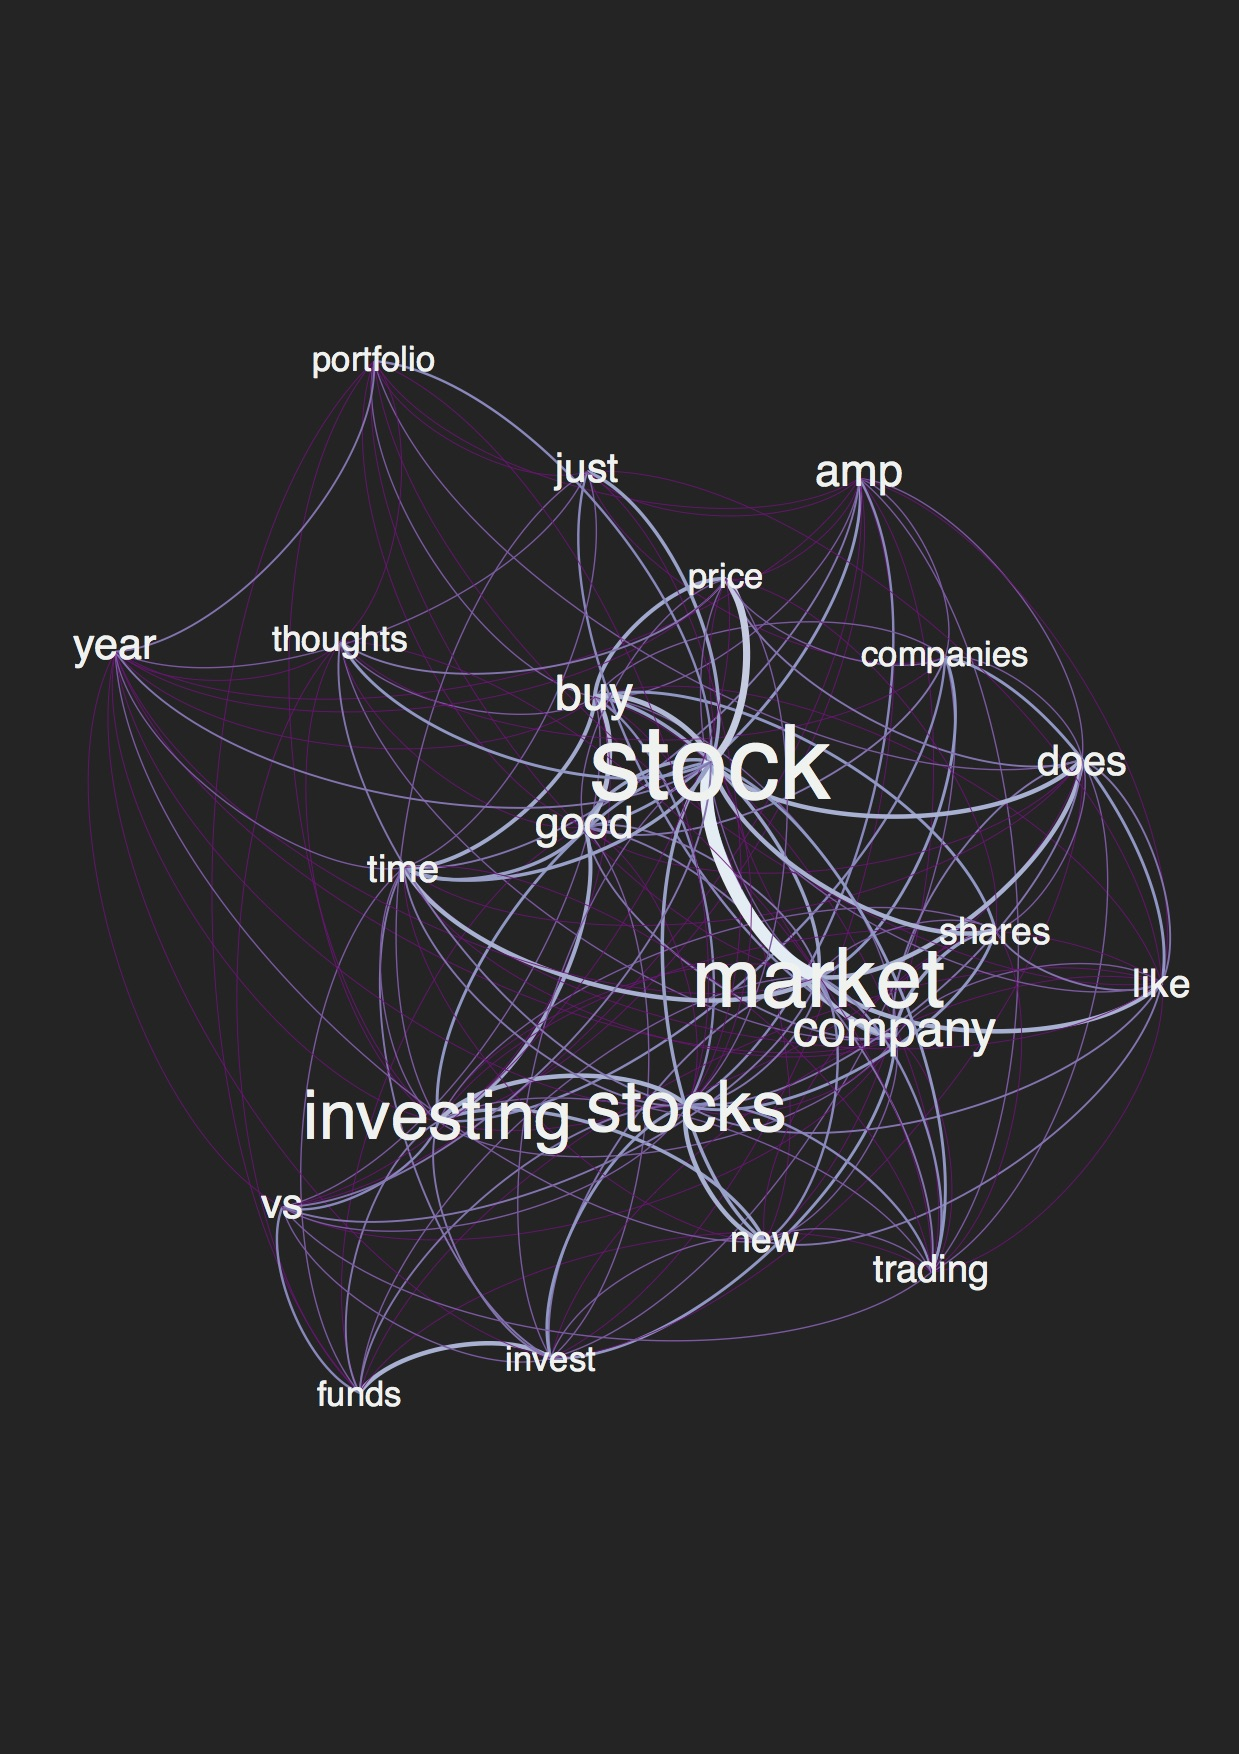

In [263]:
from IPython.display import Image
Image(filename = './images/gephi2.jpg', width = 500)

For both of the subreddits, the most frequently observed words are stock, market, investing and stocks. Words commonly observed together are stock and market, investing and stocks, buy and stock. From this graph, it can be seen that a reoccuring topic is asking others for their thoughts and comparing different funds and stocks. 

# Conclusion and Recommendations

As the accuracy score did not vary greatly from the varying models, it can be inferred that the posts between the two subreddits are too similar to accurately split into different categories. Therefore, it is recommended for new investors to focus on one subreddit rather than read both. 

However, as the model only focuses on the title of the posts and not text, the investor should look into what content they are specifically looking for. It seems as though the topics (based on titles) covered in the two subreddits are very similar. This does not directly correlate to the commentary or content of the posts. Therefore, while the topics talked about might be similar, there could be different commentary based on the subreddit. 

While the time sensitive investor might choose to focus on only one subreddit, to get a broader breadth of information it would be beneficial to stil read both subreddits. 